### Library Imports

In [63]:
import argparse
import sys
import os
import math

from Bio import PDB
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.NACCESS import NACCESS_atomic
from Bio.PDB.NeighborSearch import NeighborSearch
from Bio.PDB.PDBIO import PDBIO, Select
import biobb_structure_checking
import biobb_structure_checking.constants as cts
from biobb_structure_checking.structure_checking import StructureChecking
base_dir_path=biobb_structure_checking.__path__[0]
args = cts.set_defaults(base_dir_path,{'notebook':True})

## STEP 1
- Function **get_interface_residues** takes a structure and two chain identifiers as input along with a distance cutoff value. It uses these to find residues in each chain that are within the cutoff distance of each other, which denotes the interface between the two chains.
- Then uses this function to identify and print out the interface residues for chains A and E of our structure (6m0j_fixed.pdb).

### OPTION CODE 1

In [64]:
def get_interface_residues(structure, chain1_id, chain2_id, distance_cutoff):
    model = structure[0]

    # Extract atoms from the two specified chains
    chain1_atoms = [atom for atom in model[chain1_id].get_atoms()]
    chain2_atoms = [atom for atom in model[chain2_id].get_atoms()]

    # Create NeighborSearch objects for each chain
    ns_chain1 = NeighborSearch(chain1_atoms)
    ns_chain2 = NeighborSearch(chain2_atoms)

    # Identify interface residues by searching for neighbors in the opposite chain
    int_res_chain1 = set()
    for atom in chain1_atoms:
        neighbors_chain2 = ns_chain2.search(atom.coord, distance_cutoff)
        if neighbors_chain2:
            int_res_chain1.add(atom.get_full_id()[3][1])

    int_res_chain2 = set()
    for atom in chain2_atoms:
        neighbors_chain1 = ns_chain1.search(atom.coord, distance_cutoff)
        if neighbors_chain1:
            int_res_chain2.add(atom.get_full_id()[3][1])

    return list(int_res_chain1), list(int_res_chain2)

# load the structure 
pdb_parser = PDB.PDBParser(QUIET=True)
structure = pdb_parser.get_structure("example", "/home/irene/Documents/BIOPYISICS/step_2/6m0j_fixed.pdb")

chain1_id = "A"
chain2_id = "E"
distance = 5

# output
int_res_chain1, int_res_chain2 = get_interface_residues(structure, chain1_id, chain2_id, distance)

print(f"Interface residues in Chain {chain1_id}: {int_res_chain1}")
print(f"Interface residues in Chain {chain2_id}: {int_res_chain2}")


Interface residues in Chain A: [386, 387, 393, 19, 21, 24, 27, 28, 30, 31, 34, 35, 37, 38, 41, 42, 45, 324, 325, 326, 330, 79, 82, 83, 351, 352, 353, 354, 355, 357]
Interface residues in Chain E: [403, 417, 445, 446, 447, 449, 453, 455, 456, 473, 475, 476, 477, 484, 485, 486, 487, 489, 490, 493, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505]


### OPTION CODE 2

**Detects interface residues within a distance(dist)**

Assumes two chains, i.e. a unique interface set per chain.

In [65]:
def get_interface(st, dist):
    select_ats = []
    for at in st.get_atoms():
        # Skip Hydrogens to reduce time
        if at.element != 'H':
            select_ats.append(at)
    nbsearch = NeighborSearch(select_ats)
    interface = {}
    # Sets are more efficient than lists. Use sets when order is not relevant
    for ch in st[0]:
        interface[ch.id] = set()

    for at1, at2 in nbsearch.search_all(dist):
        #Only different chains
        res1 = at1.get_parent()
        ch1 = res1.get_parent()
        res2 = at2.get_parent()
        ch2 = res2.get_parent()
        if ch1 != ch2:
            interface[ch1.id].add(res1)
            interface[ch2.id].add(res2)
    return interface

**HERE YOU CAN MODIFY THE DISTANCE** We put 5 for the results that are displayed in the notebook

In [80]:
pdb_path = '/home/irene/Documents/BIOPYISICS/step_2/6m0j_fixed.pdb'
parser = PDBParser(PERMISSIVE=1)
dist = input("What is the distance cutoff?: ")
dist = float(dist)
st = parser.get_structure('st', pdb_path)

What is the distance cutoff?: 5


In [81]:
interface_residues = get_interface(st, distance)

# STEP 2

Add atom parameters (for step 3)

*This step is not necessary for step 2 but it will be for the step 3)*

In [82]:
ala_atoms = {'N', 'H', 'CA', 'HA', 'C', 'O', 'CB', 'HB', 'HB1', 'HB2', 'HB3', 'HA1', 'HA2', 'HA3'}

In [83]:
def residue_id(res):
    '''Returns readable residue id'''
    return '{} {}{}'.format(res.get_resname(), res.get_parent().id, res.id[1])

def atom_id(at):
    '''Returns readable atom id'''
    return '{}.{}'.format(residue_id(at.get_parent()), at.id)

def add_atom_parameters(st, res_lib, ff_params):
    ''' Adds parameters from libraries to atom .xtra field
        For not recognized atoms, issues a warning and put default parameters
    '''
    for at in st.get_atoms():
        resname = at.get_parent().get_resname()
        params = res_lib.get_params(resname, at.id)
        if not params:
            print("WARNING: residue/atom pair not in library ("+atom_id(at) + ')')
            at.xtra['atom_type'] = at.element
            at.xtra['charge'] = 0
        else:
            at.xtra['atom_type'] = params.at_type
            at.xtra['charge'] = params.charge
        at.xtra['vdw'] = ff_params.at_types[at.xtra['atom_type']]


In [84]:
def calc_int_energies(st, res):
    '''Returns interaction energies (residue against other chains)
        for all atoms and for Ala atoms
    '''
    elec = 0.
    elec_ala = 0.
    vdw = 0.
    vdw_ala = 0.

    for at1 in res.get_atoms():
        for at2 in st.get_atoms():
        # skip same chain atom pairs
            if at2.get_parent().get_parent() != res.get_parent():
                r = at1 - at2
                e = elec_int(at1, at2, r)
                elec += e
                if at1.id in ala_atoms: #GLY are included implicitly
                    elec_ala += e
                e = vdw_int(at1, at2, r)
                vdw += e
                if at1.id in ala_atoms: #GLY are included implicitly
                    vdw_ala += e
    return elec, elec_ala, vdw, vdw_ala

def MH_diel(r):
    '''Mehler-Solmajer dielectric'''
    return 86.9525 / (1 - 7.7839 * math.exp(-0.3153 * r)) - 8.5525

def elec_int(at1, at2, r):
    '''Electrostatic interaction energy between two atoms at r distance'''
    return 332.16 * at1.xtra['charge'] * at2.xtra['charge'] / MH_diel(r) / r

def vdw_int(at1, at2, r):
    '''Vdw interaction energy between two atoms'''
    eps12 = math.sqrt(at1.xtra['vdw'].eps * at2.xtra['vdw'].eps)
    sig12_2 = at1.xtra['vdw'].sig * at2.xtra['vdw'].sig
    return 4 * eps12 * (sig12_2**6/r**12 - sig12_2**3/r**6)

def calc_solvation(st, res):
    '''Solvation energy based on ASA'''
    solv = 0.
    solv_ala = 0.
    for at in res.get_atoms():
        if 'EXP_NACCESS' not in at.xtra:
            continue
        s = float(at.xtra['EXP_NACCESS'])* at.xtra['vdw'].fsrf
        solv += s
        if at.id in ala_atoms:
            solv_ala += s
    return solv, solv_ala

In [85]:
class ResiduesDataLib():
    def __init__(self, fname):
        self.residue_data = {}
        try:
            fh = open(fname, "r")
        except OSError:
            print("#ERROR while loading library file (", fname, ")")
            sys.exit(2)
        for line in fh:
            if line[0] == '#':
                continue
            data = line.split()
            r = Residue(data)
            self.residue_data[r.id] = r
        self.nres = len(self.residue_data)

    def get_params(self, resid, atid):
        atom_id = resid + ':' + atid
        if atom_id in self.residue_data:
            return self.residue_data[atom_id]
        else:
            print("WARNING: atom not found in library (", atom_id, ')')
            return None

class Residue():
    def __init__(self, data):
        self .id = data[0] + ':' + data[1]
        self.at_type = data[2]
        self.charge = float(data[3])


In [86]:
class AtomType():
    def __init__(self, data):
        self.id   = data[0]
        self.eps  = float(data[1])
        self.sig  = float(data[2])
        self.mass = float(data[3])
        self.fsrf = float(data[4])
        self.rvdw = self.sig * 0.5612
        
class VdwParamset(): #extracted from GELPI's github
    #parameters for the VdW
    def __init__ (self, file_name):
        self.at_types = {}
        try:
            fh = open(file_name, "r")
        except OSError:
            print ("#ERROR while loading parameter file (", file_name, ")")
            sys.exit(2)
        for line in fh:
            if line[0] == '#':
                continue
            data = line.split()
            self.at_types[data[0]] = AtomType(data)
        self.ntypes = len(self.at_types)
        fh.close()

Loading parameters and libraries from external files

In [87]:
NACCESS_BINARY = '/home/irene/Documents/BIOPYISICS/step_2/Parameters_solvation/soft/NACCESS/naccess'

In [88]:
res_lib = ResiduesDataLib('/home/irene/Documents/BIOPYISICS/step_2/residue_library.txt')
ff_params = VdwParamset('/home/irene/Documents/BIOPYISICS/step_2/vdwprm')

In [89]:
add_atom_parameters(st, res_lib, ff_params)


In [90]:
try:
    srf = NACCESS_atomic(st[0], naccess_binary=NACCESS_BINARY)
except Exception as e:
    print("Error:", e)

## INTERFACE RESIDUES

In [91]:
io = PDBIO()
st_chains = {}
# Using BioIO trick (see tutorial) to select chains
class SelectChain(Select):
    def __init__(self, chid):
        self.id = chid

    def accept_chain(self, chain):
        if chain.id == self.id:
            return 1
        else:
            return 0

for ch in st[0]:
    io.set_structure(st)
    io.save('tmp.pdb', SelectChain(ch.id))
    st_chains[ch.id] = parser.get_structure('stA', 'tmp.pdb')
    add_atom_parameters(st_chains[ch.id], res_lib, ff_params)
    srfA = NACCESS_atomic(st_chains[ch.id][0], naccess_binary=NACCESS_BINARY)
os.remove('tmp.pdb')


In [92]:
## Initiatlize Energy aggregates
elec = {}
elec_ala = {}

vdw = {}
vdw_ala = {}

solvAB = {}
solvAB_ala = {}

solvA = {}
solvA_ala = {}

totalIntElec = 0.
totalIntVdw = 0.
totalSolv = 0.
totalSolvMon = {}


## We get the chsin ids,not always they are A and B
chids = []
for ch in st[0]:
    chids.append(ch.id)
    totalSolvMon[ch.id] = 0

total = 0.

for ch in st[0]:
    for res in ch.get_residues():
        if dist > 0 and res not in interface_residues[ch.id]:
            continue
        
        elec[res], elec_ala[res], vdw[res], vdw_ala[res] = calc_int_energies(st[0], res)
        solvAB[res], solvAB_ala[res] = calc_solvation(st[0], res)
        solvA[res], solvA_ala[res] = calc_solvation(
            st_chains[ch.id],
            st_chains[ch.id][0][ch.id][res.id[1]]
        )
        totalIntElec += elec[res]
        totalIntVdw += vdw[res]
        totalSolv += solvAB[res]
        totalSolvMon[ch.id] += solvA[res]
        total += elec[res] + vdw[res] + solvAB[res] - solvA[res]
        
        print(
            'D#{:11} {:11.4f}{:11.4f}{:11.4f}{:11.4f} - {:11.4f}{:11.4f}{:11.4f}{:11.4f}'.format(
                residue_id(res),
                elec[res], vdw[res], solvAB[res], solvA[res],
                elec_ala[res], vdw_ala[res], solvAB_ala[res], solvA_ala[res]
            )
        )
        
        
print("Interaction energy based in interface residues only")
print('{:20}: {:11.4f}'.format('Total Elec Int.', totalIntElec))
print('{:20}: {:11.4f}'.format('Total Vdw Int.', totalIntVdw))
print('{:20}: {:11.4f}'.format('Total Solv AB', totalSolv))
print('{:19}{}: {:11.4f}'.format('Total Solv ', chids[0], totalSolvMon[chids[0]]))
print('{:19}{}: {:11.4f}'.format('Total Solv ', chids[1], totalSolvMon[chids[1]]))
print('{:20}: {:11.4f}'.format('DGintAB-A-B', total))


print(f'The total interaction energy of the interface residues is {total}')

D#SER A19          0.2146    -0.9124    -3.3193    -4.3155 -     -0.0754    -0.8309    -2.0507    -3.0470
D#GLN A24          0.3970    -3.1127    -1.6921    -2.3669 -     -0.0513    -2.2888     0.0054     0.1187
D#THR A27          0.0910    -6.3293    -0.7176     0.3967 -      0.1451    -3.4757     0.0503     0.1325
D#PHE A28         -0.0334    -3.5589     0.4867     1.4307 -      0.0063    -2.2468     0.0000     0.0269
D#ASP A30          1.5443    -2.8606    -1.6757    -3.2389 -     -0.0119    -0.6429    -0.0194     0.1087
D#LYS A31          0.7437    -7.5409    -0.2075    -2.2041 -      0.0331    -3.1152     0.0000     0.2945
D#HIE A34         -0.0984     0.0561    -1.7502    -2.7201 -     -0.0130    -1.9926    -0.0840     0.2956
D#GLU A35          0.2204    -1.9406    -1.9623    -2.6746 -     -0.0263    -0.6161     0.0077    -0.0468
D#GLU A37         -0.4083    -2.4799    -0.8292    -1.1856 -     -0.0617    -0.5009     0.0815     0.0815
D#ASP A38          0.3563    -2.6430    -0.572

## TOTAL ENERGY IN THE COMPLEX (CHAIN A AND E)

In [56]:
def calc_solvation(st, res):
    '''Solvation energy based on ASA'''
    solv = 0.

    for at in res.get_atoms():
        if 'EXP_NACCESS' not in at.xtra:
            continue
        s = float(at.xtra['EXP_NACCESS'])* at.xtra['vdw'].fsrf
        solv += s

    return solv
def calc_int_energies(st, res):
    '''Returns interaction energies (residue against other chains)
        for all atoms and for Ala atoms
    '''
    elec = 0.
    vdw = 0.

    for at1 in res.get_atoms():
        for at2 in st.get_atoms():
        # skip same chain atom pairs
            if at2.get_parent().get_parent() != res.get_parent():
                r = at1 - at2
                e = elec_int(at1, at2, r)
                elec += e
                
                e = vdw_int(at1, at2, r)
                vdw += e

    return elec + vdw



def compute_energy_interface(st, all_res):
    total_molec_energy = 0.0
    energy_vdw_elect = 0.0
    energy_solv_complex = 0.0
    energy_solv_A = 0.0
    energy_solv_B = 0.0
    
    for chain, conjunt in all_res.items():
        for residue in conjunt:
            energy_vdw_elect += calc_int_energies(st, residue)
            energy_solv_complex += calc_solvation(st, residue)
            
            if chain == 'A': # We compute the solvation energy of the residues of the A chain
                energy_solv_A += calc_solvation(st, residue)

            else: # We compute the solvation energy of the residues of the E chain
                energy_solv_B += calc_solvation(st, residue)

                
    total_molec_energy = (energy_vdw_elect + energy_solv_complex - energy_solv_A - energy_solv_B) # We compute the total energy

    return energy_vdw_elect, energy_solv_complex, energy_solv_A, energy_solv_B, total_molec_energy

In [59]:
total_molec_energy = 0.0
energy_vdw_elect = 0.0
energy_solv_complex = 0.0
energy_solv_A = 0.0
energy_solv_B = 0.0
model = st[0] # We only have one model.

for chain in model.get_chains(): # We iterate over the 2 chains, A and E. 
    for residue in chain.get_residues(): # We iterate over all the residues of the structure
        energy_vdw_elect += calc_int_energies(st, residue) # We compute all vdw and electrostatic energies of all residues
        energy_solv_complex += calc_solvation(model, residue) # We compute all solvation energy of the residues of the complex AE
        if chain.id == 'A': # We compute the solvation energy of the residues of the A chain
            energy_solv_A += calc_solvation(st_chains['A'], st[0]['A'][residue.id[1]])
        else: # We compute the solvation energy of the residues of the E chain
            energy_solv_B += calc_solvation(st_chains['E'], st[0]['E'][residue.id[1]])


total_molec_energy = (energy_vdw_elect + energy_solv_complex - energy_solv_A - energy_solv_B) # We compute the total energy

print("Interaction energy of residues in the complex")
print('{:20}: {:11.4f}'.format('Total Elec Int & Vdw Int.', energy_vdw_elect))
print('{:20}: {:11.4f}'.format('Total Solv AB', energy_solv_complex))
print('{:19}{}: {:11.4f}'.format('Total Solv ', chids[0], energy_solv_A))
print('{:19}{}: {:11.4f}'.format('Total Solv ', chids[1],energy_solv_B))
print('{:20}: {:11.4f}'.format('DGintAB-A-B', total_molec_energy))


Interaction energy of residues in the complex
Total Elec Int & Vdw Int.:   -176.7422
Total Solv AB       :   -507.1030
Total Solv         A:   -398.5663
Total Solv         E:   -108.5366
DGintAB-A-B         :   -176.7422


## STEP 3

In [61]:
print("Ala Scanning: DDGs for X->Ala mutations on interface residues")
f = open("plot_alanines.txt", "w")
for ch in st[0]:
    for res in ch.get_residues():
        if dist > 0 and res not in interface_residues[ch.id]:
            continue
        print(
            '{:11} {:11.4f}{:11.4f}{:11.4f}{:11.4f}{:11.4f}'.format(
                ch.id + ' '+ residue_id(res),
                - elec[res] + elec_ala[res],
                - vdw[res] + vdw_ala[res],
                - solvAB[res] + solvAB_ala[res],
                - solvA[res] + solvA_ala[res],
                - elec[res] + elec_ala[res] - vdw[res] + vdw_ala[res] -solvAB[res] +\
                    solvAB_ala[res] -solvA[res] + solvA_ala[res]
            ), file = f
        )
        
f.close()
    

Ala Scanning: DDGs for X->Ala mutations on interface residues


**ADDITIONAL CODE FOR A HIGHLITED PLOT**

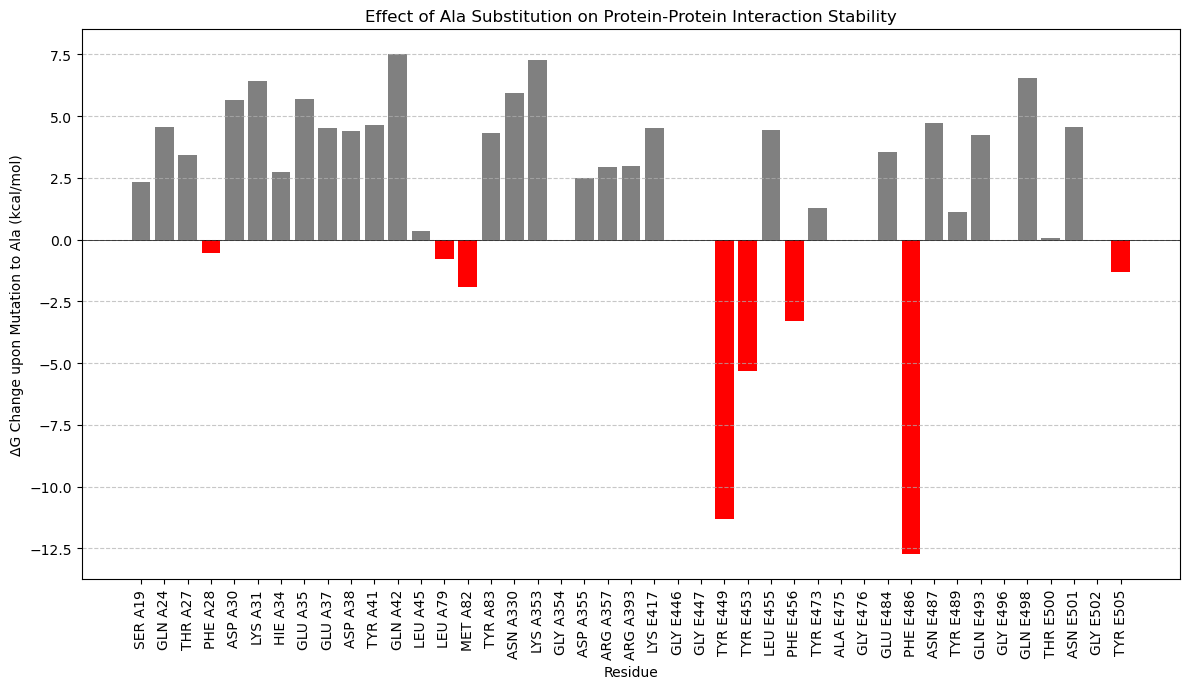

In [98]:
import matplotlib.pyplot as plt

# Now your existing plotting code will work.
mutational_energies = []
residue_names = []

with open('/home/irene/Documents/BIOPYISICS/step_2/plot_alanines.txt', 'r') as file:
    alanine_scanning_data = file.readlines()

for line in alanine_scanning_data:
    parts = line.split()
    residue_names.append(parts[1] + " " + parts[2])
    mutational_energies.append(float(parts[-1]))

# Bar colors: residues with a high impact on stability will be highlighted in red.
colors = ['red' if energy < 0 else 'grey' for energy in mutational_energies]

# Create the bar plot
plt.figure(figsize=(12, 7))
plt.bar(residue_names, mutational_energies, color=colors)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Label the axes and the title
plt.xlabel('Residue')
plt.ylabel('ΔG Change upon Mutation to Ala (kcal/mol)')
plt.title('Effect of Ala Substitution on Protein-Protein Interaction Stability')

# Highlight the zero line
plt.axhline(0, color='black', linewidth=0.5)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
